In [1]:
import os
import sys
import json
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

import seaborn as sns

import IPython.display

import ipywidgets as widgets

# Contents <a name="contents"></a>

- [General Analysis](#general)
- [Comparison across different number of off-manifold points](#cmpr_num_off_mfld_k2n500)

## General Analysis <a name="general"></a> [\[top\]](#contents)

In [2]:
def disp_query_plot(query, response_df, style):
    if query["task"] == "clf":
        if style == "sct_plot":
            fig = plt.figure()
            plt.title("sct plot not available for stdclf")
            plt.show()
            
        elif style == "adv_pct_cm" or style == "pct_cm":
            f, axarr = plt.subplots(1, 2)
            f.set_size_inches(10, 4)
            img = pd.read_csv(response_df.pct_cm.tolist()[0], index_col=0)
            sns.heatmap(img, ax=axarr[0], annot=True)
            axarr[0].set_title("normal pct cm")
            img = pd.read_csv(response_df.adv_pct_cm.tolist()[0], index_col=0)
            sns.heatmap(img, ax=axarr[1], annot=True)
            axarr[1].set_title("adv pct cm")
            f.set_tight_layout(True)
            plt.show()

    elif query["task"] == "dist":
        clf_query = copy.deepcopy(query)
        clf_query.pop("thresh")
        clf_query["task"] = "clf"
        clf_response_df = master_df[(master_df[list(clf_query.keys())] == pd.Series(clf_query)).all(1)]
        
        if style == "adv_pct_cm":
            fig = plt.figure(constrained_layout=True)
            fig.set_size_inches(10, 4)
            ax_dict = fig.subplot_mosaic(
                [
                    ["dist_adv_pct_cm", "clf_adv_pct_cm"],
                ]
            )

            dist_adv_pct_cm = pd.read_csv(response_df.adv_pct_cm.tolist()[0], index_col=0)
            sns.heatmap(dist_adv_pct_cm, ax=ax_dict["dist_adv_pct_cm"], annot=True)
            ax_dict["dist_adv_pct_cm"].set_title("distlearn: adv pct cm")

            clf_adv_pct_cm = pd.read_csv(clf_response_df.adv_pct_cm.tolist()[0], index_col=0)
            sns.heatmap(clf_adv_pct_cm, ax=ax_dict["clf_adv_pct_cm"], annot=True)
            ax_dict["clf_adv_pct_cm"].set_title("stdclf: adv pct cm")

        elif style == "pct_cm":
            fig = plt.figure(constrained_layout=True)
            fig.set_size_inches(10, 4)
            ax_dict = fig.subplot_mosaic(
                [
                    ["dist_pct_cm", "clf_pct_cm"]
                ]
            )

            dist_pct_cm = pd.read_csv(response_df.pct_cm.tolist()[0], index_col=0)
            sns.heatmap(dist_pct_cm, ax=ax_dict["dist_pct_cm"], annot=True)
            ax_dict["dist_pct_cm"].set_title("distlearn: pct cm")

            clf_pct_cm = pd.read_csv(clf_response_df.pct_cm.tolist()[0], index_col=0)
            sns.heatmap(clf_pct_cm, ax=ax_dict["clf_pct_cm"], annot=True)
            ax_dict["clf_pct_cm"].set_title("stdclf: pct cm")
            
        elif style == "sct_plot":
            fig = plt.figure(constrained_layout=True)
            fig.set_size_inches(8, 6)
            ax_dict = fig.subplot_mosaic(
                [
                    ["sct_plot"],

                ]
            )

            img = mpimg.imread(response_df.distance_sct_plt.tolist()[0])
            ax_dict["sct_plot"].imshow(img)
            ax_dict["sct_plot"].set_title("distance sct plt")
        
        plt.show()


In [3]:
def make_interactive_query_system(master_df):
    
    INP_COLS = ["atk_flavor", "atk_routine", "eps", "eps_iter", "norm", "restarts", "verbose", "k", "n", "max_norm", "task", "N", "thresh"]

    input_widgets = list()

    for col in INP_COLS:

        uniq_vals = master_df[col].fillna(value=-1).unique()

        input_widgets.append(widgets.Dropdown(
            options=uniq_vals,
            value=uniq_vals[0],
            description=col,
            disabled=False
        ))
    
    
    output_style = widgets.Dropdown(
            options=["adv_pct_cm", "sct_plot", "pct_cm"],
            value="adv_pct_cm",
            description="display style",
            disabled=False
        )
    
    
    
    button = widgets.Button(
        description='Submit',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Submit',
        icon='check' # (FontAwesome names without the `fa-` prefix)
    )
    
    
    output = widgets.Output()
    input_widgets.append(button)
    display_for_inputs = widgets.GridBox(input_widgets[:-1] + [output_style] + [input_widgets[-1]], layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))
    display(display_for_inputs)
    
    def on_button_clicked(b):
        with output:
            IPython.display.clear_output(wait=True) 
            query = {i.description: i.value for i in input_widgets[:-1]}
            if query["task"] == "clf": query.pop("thresh")

            display_for_inputs = widgets.GridBox(input_widgets[:-1] + [output_style] + [input_widgets[-1]], layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))
            response_df = master_df[(master_df[list(query.keys())] == pd.Series(query)).all(1)]
            style = output_style.value
            disp_query_plot(query, response_df, style)
        
        display(display_for_inputs)  
        display(output)
        IPython.display.clear_output(wait=True) 
            
    input_widgets[-1].on_click(on_button_clicked)
    IPython.display.clear_output(wait=True)   

In [4]:
DUMP_DIR = "../../dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/attack_perfs_on_runs/all_attack_perfs_fixed_07022022/"
tag_match = ["moreoffmfld", "clf"]
tag_not_match = ["v2", "v3"]
master_df = None

for file in os.listdir(DUMP_DIR):
    if not file.endswith(".json"):
        print(file)
        continue
    skip = False
    for match in tag_match:
        if match not in file:
            skip=True
        elif match in file:
            skip=False
            break
    for match in tag_not_match:
        if match in file:
            skip=True
    if skip:
        print(file)
        continue
    if master_df is None:
        master_df = pd.read_json(os.path.join(DUMP_DIR, file))
    else:

        tmp = pd.read_json(os.path.join(DUMP_DIR, file))
        master_df = pd.concat([master_df, tmp], ignore_index=True)

columns = master_df.columns.tolist()
drop_dup_by_columns = [i for i in columns if "clf_report" not in i]
master_df.drop_duplicates(drop_dup_by_columns, inplace=True)

rdm_concspheres_k2n500_noninfdist_moreoffmfldv2-regression.json
rdm_concspheres_k2n500_noninfdist_upmn-regression.json
rdm_concspheres_k2n500_noninfdist-regression.json
rdm_concspheres_k50n500_noninfdist-regression.json
rdm_concspheres_k500n500_noninfdist-regression.json
.ipynb_checkpoints


In [5]:
make_interactive_query_system(master_df)

GridBox(children=(Dropdown(description='atk_flavor', options=('std_pgd',), value='std_pgd'), Dropdown(descript…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 720x288 with 4 Axes>', 'i…

# Comparing across different number of off-manifold points <a name="cmpr_num_off_mfld_k2n500"></a> [\[top\]](#contents)

- For k = 2, n = 500: load v2 and normal run separately
- For k = 50, n = 500: load v3 and normal run separately

In [6]:
DUMP_DIR = "../../dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/attack_perfs_on_runs/all_attack_perfs_fixed_07022022/"


k2n500_dl_v1 = os.path.join(DUMP_DIR, "rdm_concspheres_k2n500_noninfdist_moreoffmfld-regression.json")
k2n500_dl_v2 = os.path.join(DUMP_DIR, "rdm_concspheres_k2n500_noninfdist_moreoffmfldv2-regression.json")
k2n500_stdclf = os.path.join(DUMP_DIR, "rdm_concspheres_k2n500_noninfdist-clf.json")




In [7]:
v1_list = [
    k2n500_dl_v1,
    k2n500_stdclf
]
master_df_v1 = None
for file in v1_list:
    if not file.endswith(".json"):
        continue
    if master_df_v1 is None:
        master_df_v1 = pd.read_json(file)
    else:
        tmp = pd.read_json(file)
        master_df_v1 = pd.concat([master_df_v1, tmp], ignore_index=True)

columns_v1 = master_df_v1.columns.tolist()
drop_dup_by_columns_v1 = [i for i in columns_v1 if "clf_report" not in i]
master_df_v1.drop_duplicates(drop_dup_by_columns_v1, inplace=True)


v2_list = [
    k2n500_dl_v2,
    k2n500_stdclf
]
master_df_v2 = None
for file in v2_list:
    if not file.endswith(".json"):
        continue
    if master_df_v2 is None:
        master_df_v2 = pd.read_json(file)
    else:
        tmp = pd.read_json(file)
        master_df_v2 = pd.concat([master_df_v2, tmp], ignore_index=True)

columns_v2 = master_df_v2.columns.tolist()
drop_dup_by_columns_v2 = [i for i in columns_v2 if "clf_report" not in i]
master_df_v2.drop_duplicates(drop_dup_by_columns_v2, inplace=True)


In [8]:
make_interactive_query_system(master_df_v1)

GridBox(children=(Dropdown(description='atk_flavor', options=('std_pgd',), value='std_pgd'), Dropdown(descript…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 720x288 with 4 Axes>', 'i…

In [9]:
make_interactive_query_system(master_df_v2)

GridBox(children=(Dropdown(description='atk_flavor', options=('std_pgd',), value='std_pgd'), Dropdown(descript…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 720x288 with 4 Axes>', 'i…

In [4]:
DUMP_DIR = "../../dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/attack_perfs_on_runs/all_attack_perfs_fixed_07022022/"
master_df = None
for file in os.listdir(DUMP_DIR):
    if not file.endswith(".json"):
        continue
    if master_df is None:
        master_df = pd.read_json(os.path.join(DUMP_DIR, file))
    else:

        tmp = pd.read_json(os.path.join(DUMP_DIR, file))
        master_df = pd.concat([master_df, tmp], ignore_index=True)

columns = master_df.columns.tolist()
drop_dup_by_columns = [i for i in columns if "clf_report" not in i]
master_df.drop_duplicates(drop_dup_by_columns, inplace=True)

INP_COLS = ["atk_flavor", "atk_routine", "eps", "eps_iter", "norm", "restarts", "verbose", "k", "n", "max_norm", "task", "N", "thresh"]

input_widgets = list()

for col in INP_COLS:
    print(col, master_df[col].unique())
    uniq_vals = master_df[col].fillna(value=-1).unique()
    
    input_widgets.append(widgets.Dropdown(
        options=uniq_vals,
        value=uniq_vals[0],
        description=col,
        disabled=False
    ))

atk_flavor ['std_pgd']
atk_routine ['my' 'chans']
eps [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
eps_iter [0.005 0.006 0.007 0.008 0.009]
norm [2]
restarts [1]
verbose [False]
k [ 50   2 500]
n [500]
max_norm [0.1]
task ['clf' 'dist']
N [200000]
thresh [ nan  inf 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12
 0.13 0.14 0.15]


In [5]:
master_df.shape

(2700, 25)

In [38]:
display_for_inputs = widgets.GridBox(input_widgets, layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))

In [39]:
display(display_for_inputs)

GridBox(children=(Dropdown(description='atk_flavor', options=('std_pgd',), value='std_pgd'), Dropdown(descript…

In [79]:
query = {i.description: i.value for i in input_widgets}
if query["task"] == "clf": query.pop("thresh")


In [82]:
query["task"]

'dist'

In [85]:
response_df = master_df[(master_df[list(query.keys())] == pd.Series(query)).all(1)]
response_df

,atk_flavor,atk_routine,eps,eps_iter,nb_iter,norm,restarts,verbose,k,n,...,tgtname,thresh,adv_clf_report,adv_abs_cm,adv_pct_cm,clf_report,abs_cm,pct_cm,distance_sct_plt,result_dir
12900,std_pgd,my,0.01,0.005,100,2,1,False,50,500,...,normed_actual_distances,inf,"{'0': {'precision': 0.9998000359935211, 'recal...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...


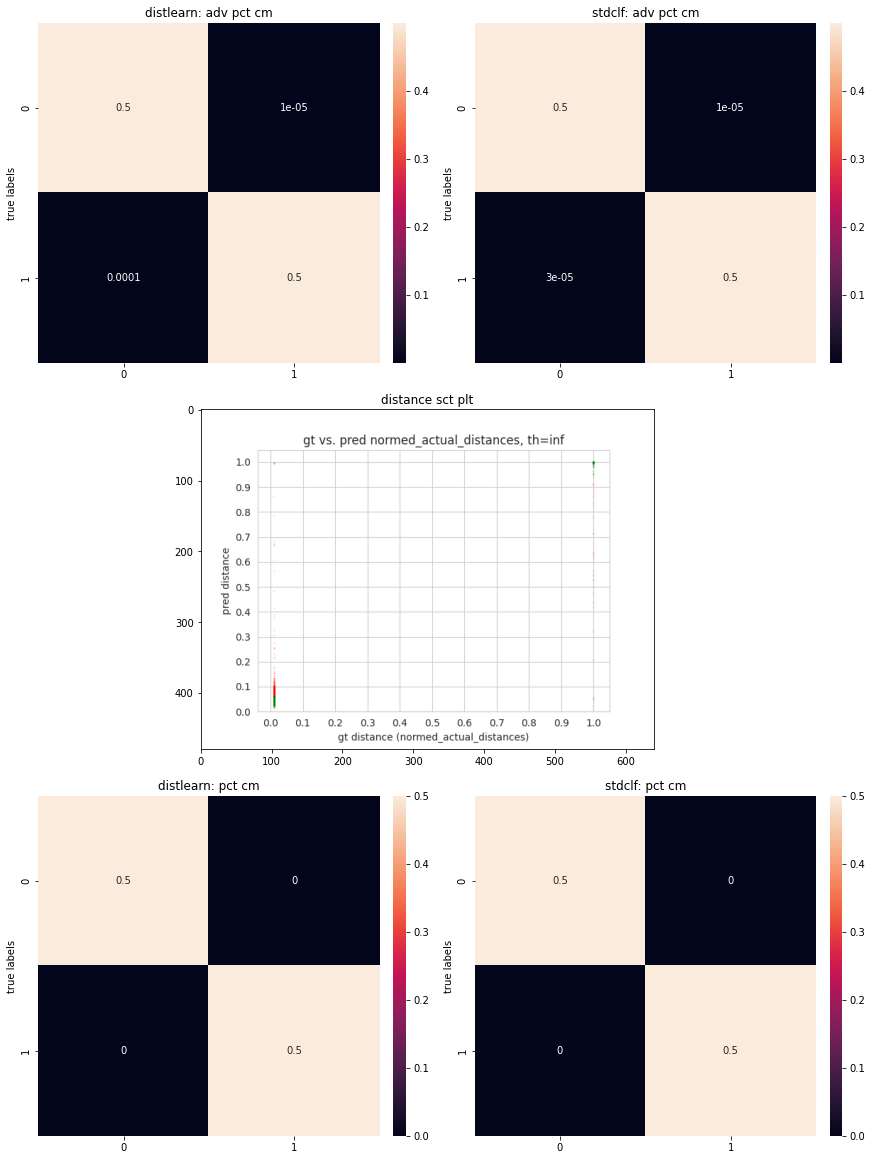

In [84]:
disp_query_plot(query, response_df)

In [66]:
response_df.pct_cm.tolist()[0]

'/data/dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/rdm_concspheres_k50n500_noninfdist/1/attack_perf/atk_flavor=std_pgd,atk_routine=my,eps=0.01,eps_iter=0.005,nb_iter=100,norm=2,restarts=1,verbose=False,task=dist/pct_cm_plots_test/pct_cm_test_th=inf.csv'

In [29]:
master_df[master_df["thresh"] >= 0.15]

,atk_flavor,atk_routine,eps,eps_iter,nb_iter,norm,restarts,verbose,k,n,...,tgtname,thresh,adv_clf_report,adv_abs_cm,adv_pct_cm,clf_report,abs_cm,pct_cm,distance_sct_plt,result_dir
100,std_pgd,my,0.01,0.005,100,2,1,False,2,500,...,normed_actual_distances,inf,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...
101,std_pgd,my,0.01,0.005,100,2,1,False,2,500,...,normed_actual_distances,inf,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...
102,std_pgd,my,0.01,0.005,100,2,1,False,2,500,...,normed_actual_distances,inf,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...
103,std_pgd,my,0.01,0.005,100,2,1,False,2,500,...,normed_actual_distances,inf,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...
104,std_pgd,my,0.01,0.005,100,2,1,False,2,500,...,normed_actual_distances,inf,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38539,std_pgd,my,0.10,0.009,100,2,1,False,500,500,...,normed_actual_distances,0.15,"{'0': {'precision': 0.9626609020339981, 'recal...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,None,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...
38554,std_pgd,my,0.10,0.009,100,2,1,False,500,500,...,normed_actual_distances,0.15,"{'0': {'precision': 0.9626609020339981, 'recal...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,None,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...
38569,std_pgd,my,0.10,0.009,100,2,1,False,500,500,...,normed_actual_distances,0.15,"{'0': {'precision': 0.9626609020339981, 'recal...",/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,None,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...,/data/dumps/expC_dist_learner_for_adv_ex/rdm_c...
38

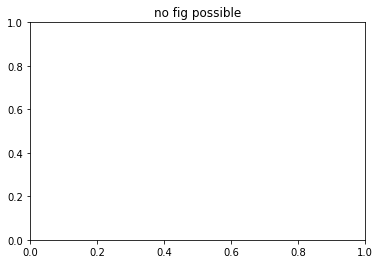

In [10]:
fig = plt.figure()
plt.title("no fig possible")
fig.show()